In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import corrections as cor

In [2]:
#Variable definitions
#Track Phi and Dp are relative to the central angle and momentum
#For each kin, they will have the same spread around that central value due to common acceptance cuts
th_bins = np.arange(-2.25,2.251,.5)
th_bc   = np.arange(-2,2.1,.5)
dp_bins = np.arange(-.035,.0451,.01)
dp_bc   = np.arange(-.03,.041,.01)

#String of kins used for finding the runlists
kins = ['0','1','2','3','4','5','7_1st','7_2nd','9_1st','9_2nd','11_1st','11_2nd','13_1st','13_2nd','15_1st','15_2nd','15_3rd','16_1st','16_2nd']

#Central angle for each kin
th_center = [16.811, 17.572, 19.112, 20.575, 21.940, 23.207, 25.586, 25.586, 27.764, 27.764, 29.809, 29.809, 31.728, 31.728, 33.555, 33.555, 33.555, 36.120, 36.120]

#List containers for the Yield dataframes
He3_th_series = []
He3_dp_series = []

H2_th_series = []
H2_dp_series = []

#Run Metadata
meta = pd.read_csv("ev_clean/meta.csv",index_col='run')

#Vectorize radians to degrees
deg = np.vectorize(math.degrees)

In [3]:
#Helium-3

for i,kin in enumerate(kins):
    #Define theta bins for the kin
    thetas = [th + th_center[i] for th in th_bc]
    th_edges = [th + th_center[i] for th in th_bins]
    
    #Define E` bins
    if kin.startswith('16'):
        dps = [2.9*(1+dp) for dp in dp_bc]
        dp_edges = [2.9*(1+dp) for dp in dp_bins]
    else:
        dps = [3.1*(1+dp) for dp in dp_bc]
        dp_edges = [3.1*(1+dp) for dp in dp_bins]
    
    #Charge of the kinematic
    kinQ = 0
    
    #Dataframes to hold the yields
    th_kin = pd.DataFrame(columns=['Counts', 'Yield', 'StatErr'], index = thetas)
    th_kin.index.name = 'BinCenter'
    dp_kin = pd.DataFrame(columns=['Counts', 'Yield', 'StatErr'], index = dps)
    dp_kin.index.name = 'BinCenter'
    
    #Initialize values to zero (unnecessary?)
    th_kin['Counts'].values[:]=0
    dp_kin['Counts'].values[:]=0
    th_kin['Yield'].values[:]=0
    dp_kin['Yield'].values[:]=0
    th_kin['StatErr'].values[:]=0
    dp_kin['StatErr'].values[:]=0
    
    try:
        with open("runlists/He3_kin"+kin+".dat","r") as f:
            data = f.read().splitlines()
                        
            for run in data:
                #Load run
                ev = pd.read_csv("ev_clean/" + run + ".csv")
                
                #Run-by-run counter for applying run-by-run corrections
                th_run = pd.DataFrame(columns=['Counts'], index = thetas)
                th_run.Counts.values[:]=0
                dp_run = pd.DataFrame(columns=['Counts'], index = dps)
                dp_run.Counts.values[:]=0
                
                #Assign each event a bin
                ev['th_bin'] = np.digitize(deg(ev.angle),th_edges)
                ev['dp_bin'] = np.digitize(ev.Momentum, dp_edges)
                
                #Add counts to bins in yield dataframes
                for j in range(len(thetas)):
                    th_run.Counts.iat[j] = ev.query('th_bin=='+str(j+1)).shape[0]
                    th_kin.Counts.iat[j] = th_kin.Counts.iat[j] + th_run.Counts.iat[j]
                for j in range(len(dps)):
                    dp_run.Counts.iat[j] = ev.query('dp_bin=='+str(j+1)).shape[0]
                    dp_kin.Counts.iat[j] = dp_kin.Counts.iat[j] + dp_run.Counts.iat[j]
                
                #Add in this runs charge
                kinQ = kinQ + meta.at[int(run),'Q']
                
                #Apply run by run yield corrections
                th_kin.Yield = th_kin.Yield.add(th_run.Counts.apply(lambda x: x/(meta.at[int(run),'lt']*cor.He3Nuclei(meta.at[int(run),'avgI']))))
                dp_kin.Yield = dp_kin.Yield.add(dp_run.Counts.apply(lambda x: x/(meta.at[int(run),'lt']*cor.He3Nuclei(meta.at[int(run),'avgI']))))
                #Testing stupid stuff
                #th_kin.Yield = th_kin.Yield.add(th_kin.Counts.apply(lambda x: x))
                #dp_kin.Yield = dp_kin.Yield.add(dp_kin.Counts.apply(lambda x: x))
    except FileNotFoundError:
        print ("./runlists/He3_kin"+kin+".dat" + " File doesn't exist. Skipping kinematic.")
    except TypeError:
        print ("TypeError on " + kin + " " + run)
    #Charge normalization
    th_kin.Yield = th_kin.Yield.apply(lambda x: x/(3*kinQ))
    dp_kin.Yield = dp_kin.Yield.apply(lambda x: x/(3*kinQ))
    
    #Calculate Statistical Error
    th_kin.StatErr = th_kin.Counts.apply(lambda x: 1/(x**(1/2)) if x>0 else 0)
    dp_kin.StatErr = dp_kin.Counts.apply(lambda x: 1/(x**(1/2)) if x>0 else 0)
    
    #"Save" the dataframes for further plotting
    He3_th_series.append(th_kin)
    He3_dp_series.append(dp_kin)

In [4]:
#Deuterium

for i,kin in enumerate(kins):
    #Define theta bins for the kin
    thetas = [th + th_center[i] for th in th_bc]
    th_edges = [th + th_center[i] for th in th_bins]

    
    #Define E` bins
    if kin.startswith('16'):
        dps = [2.9*(1+dp) for dp in dp_bc]
        dp_edges = [2.9*(1+dp) for dp in dp_bins]
    else:
        dps = [3.1*(1+dp) for dp in dp_bc]
        dp_edges = [3.1*(1+dp) for dp in dp_bins]
    
    #Charge of the kinematic
    kinQ = 0
    
    #Dataframes to hold the yields
    th_kin = pd.DataFrame(columns=['Counts', 'Yield', 'StatErr'], index = thetas)
    th_kin.index.name = 'BinCenter'
    dp_kin = pd.DataFrame(columns=['Counts', 'Yield', 'StatErr'], index = dps)
    dp_kin.index.name = 'BinCenter'
    
    #Initialize values to zero (unnecessary?)
    th_kin['Counts'].values[:]=0
    dp_kin['Counts'].values[:]=0
    th_kin['Yield'].values[:]=0
    dp_kin['Yield'].values[:]=0
    th_kin['StatErr'].values[:]=0
    dp_kin['StatErr'].values[:]=0
    
    try:
        with open("runlists/D2_kin"+kin+".dat","r") as f:
            data = f.read().splitlines()
                        
            for run in data:
                #Load run
                ev = pd.read_csv("ev_clean/" + run + ".csv")
                
                #Run-by-run counter for applying run-by-run corrections
                th_run = pd.DataFrame(columns=['Counts'], index = thetas)
                th_run.Counts.values[:]=0
                dp_run = pd.DataFrame(columns=['Counts'], index = dps)
                dp_run.Counts.values[:]=0
                
                #Assign each event a bin
                ev['th_bin'] = np.digitize(deg(ev.angle),th_edges)
                ev['dp_bin'] = np.digitize(ev.Momentum, dp_edges)
                
                #Add counts to bins in yield dataframes
                for j in range(len(thetas)):
                    th_run.Counts.iat[j] = ev.query('th_bin=='+str(j+1)).shape[0]
                    th_kin.Counts.iat[j] = th_kin.Counts.iat[j] + th_run.Counts.iat[j]
                for j in range(len(dps)):
                    dp_run.Counts.iat[j] = ev.query('dp_bin=='+str(j+1)).shape[0]
                    dp_kin.Counts.iat[j] = dp_kin.Counts.iat[j] + dp_run.Counts.iat[j]
                
                #Add in this runs charge
                kinQ = kinQ + meta.at[int(run),'Q']
                
                #Apply run by run yield corrections
                th_kin.Yield = th_kin.Yield.add(th_run.Counts.apply(lambda x: x/(meta.at[int(run),'lt']*cor.H2Nuclei(meta.at[int(run),'avgI']))))
                dp_kin.Yield = dp_kin.Yield.add(dp_run.Counts.apply(lambda x: x/(meta.at[int(run),'lt']*cor.H2Nuclei(meta.at[int(run),'avgI']))))
                #Testing stupid stuff
                #th_kin.Yield = th_kin.Yield.add(th_kin.Counts)
                #dp_kin.Yield = dp_kin.Yield.add(dp_kin.Counts)
    except FileNotFoundError:
        print ("./runlists/D2_kin"+kin+".dat" + " File doesn't exist. Skipping kinematic.")
    except TypeError:
        print ("TypeError on " + kin + " " + run)
    #Charge normalization
    th_kin.Yield = th_kin.Yield.apply(lambda x: x/(2*kinQ))
    dp_kin.Yield = dp_kin.Yield.apply(lambda x: x/(2*kinQ))
    
    #Calculate Statistical Error
    th_kin.StatErr = th_kin.Counts.apply(lambda x: 1/(x**(1/2)) if x>0 else 0)
    dp_kin.StatErr = dp_kin.Counts.apply(lambda x: 1/(x**(1/2)) if x>0 else 0)
    
    #"Save" the dataframes for further plotting
    H2_th_series.append(th_kin)
    H2_dp_series.append(dp_kin)

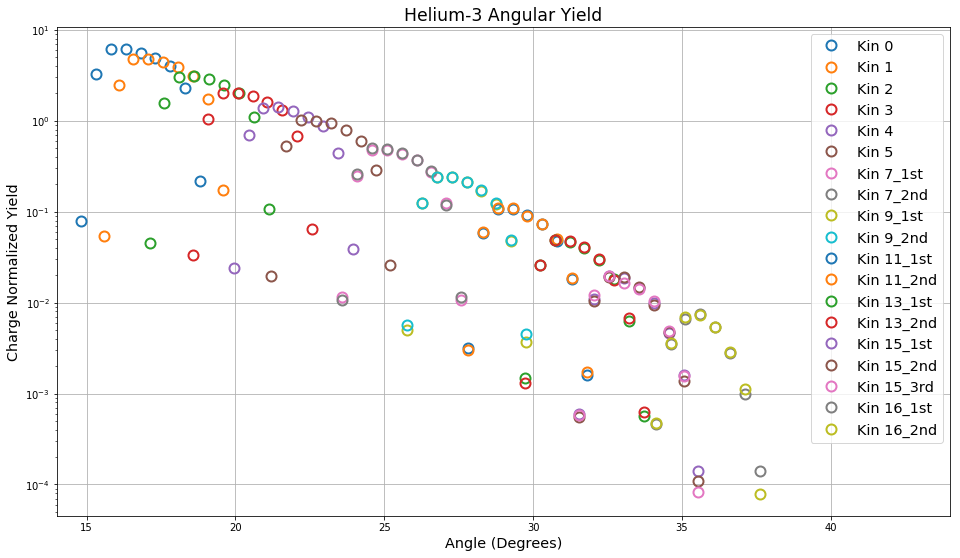

In [5]:
plt.figure(figsize=(16,9))
#,'o',
for i,kin in enumerate(kins):
    plt.plot(pd.Series(He3_th_series[i].index),He3_th_series[i]['Yield'],'o',fillstyle='none',label="Kin " + kin,ms=10,mew=2)

plt.gca().set(xlim=(14,44))
plt.title('Helium-3 Angular Yield',fontsize='xx-large')
plt.xlabel('Angle (Degrees)',fontsize='x-large')
plt.ylabel('Charge Normalized Yield',fontsize='x-large')
plt.yscale('log')
#plt.xticks(np.arange(0.1,0.901,0.1),fontsize='large')
#plt.yticks(np.arange(0,30.01,5),fontsize='large')
plt.legend(loc=1,fontsize='x-large')
plt.grid()
plt.savefig("th_series/He3_angle.jpg")

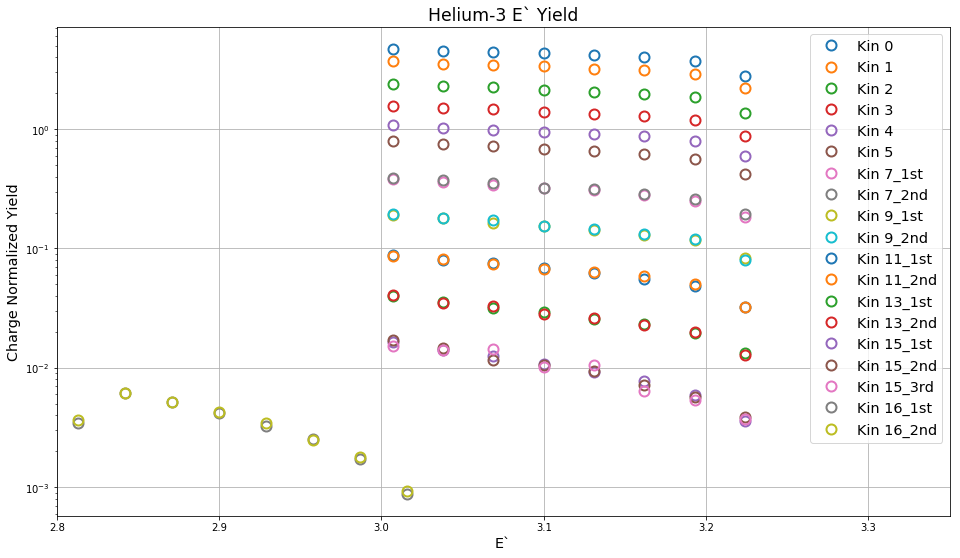

In [6]:
plt.figure(figsize=(16,9))
#,'o',
for i,kin in enumerate(kins):
    plt.plot(pd.Series(He3_dp_series[i].index),He3_dp_series[i]['Yield'],'o',fillstyle='none',label="Kin " + kin,ms=10,mew=2)

plt.gca().set(xlim=(2.8,3.35))
plt.title('Helium-3 E` Yield',fontsize='xx-large')
plt.xlabel('E`',fontsize='x-large')
plt.ylabel('Charge Normalized Yield',fontsize='x-large')
plt.yscale('log')
#plt.xticks(np.arange(0.1,0.901,0.1),fontsize='large')
#plt.yticks(np.arange(0,30.01,5),fontsize='large')
plt.legend(loc=1,fontsize='x-large')
plt.grid()
plt.savefig("ep_series/He3_ep.jpg")

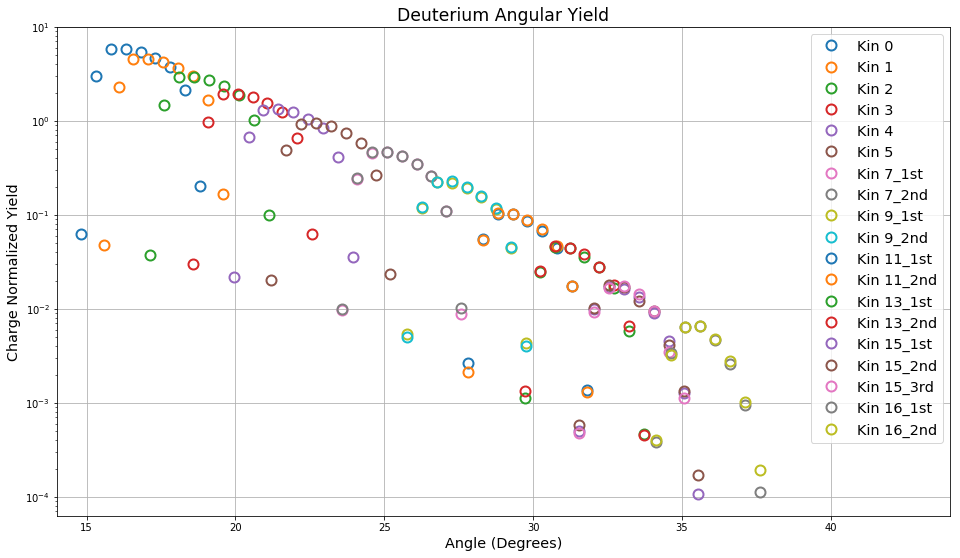

In [7]:
plt.figure(figsize=(16,9))
#,'o',
for i,kin in enumerate(kins):
    plt.plot(pd.Series(H2_th_series[i].index),H2_th_series[i]['Yield'],'o',fillstyle='none',label="Kin " + kin,ms=10,mew=2)

plt.gca().set(xlim=(14,44))
plt.title('Deuterium Angular Yield',fontsize='xx-large')
plt.xlabel('Angle (Degrees)',fontsize='x-large')
plt.ylabel('Charge Normalized Yield',fontsize='x-large')
plt.yscale('log')
#plt.xticks(np.arange(0.1,0.901,0.1),fontsize='large')
#plt.yticks(np.arange(0,30.01,5),fontsize='large')
plt.legend(loc=1,fontsize='x-large')
plt.grid()
plt.savefig("th_series/D2_angle.jpg")

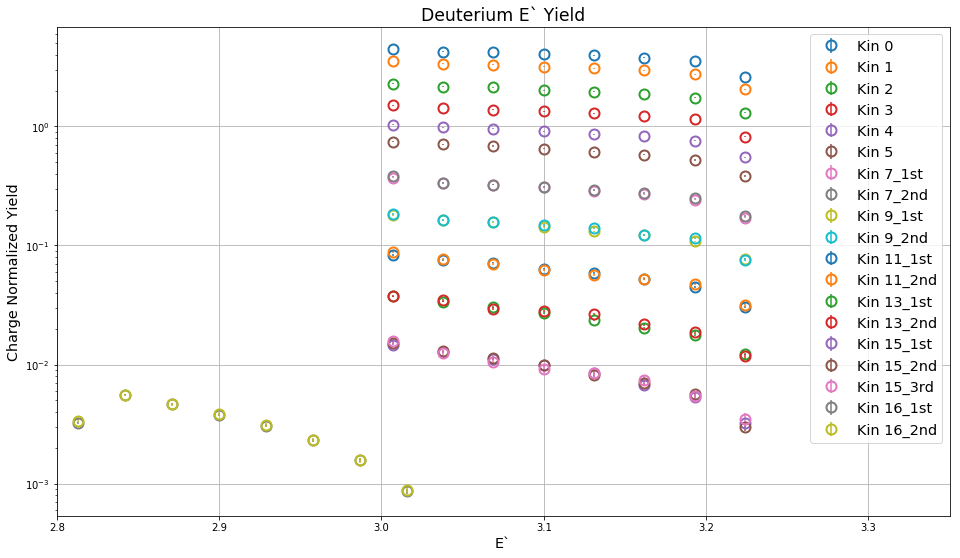

In [8]:
plt.figure(figsize=(16,9))
#,'o',
for i,kin in enumerate(kins):
    plt.errorbar(pd.Series(H2_dp_series[i].index),H2_dp_series[i]['Yield'],H2_dp_series[i]['StatErr']*H2_dp_series[i]['Yield'],fmt='o',fillstyle='none',label="Kin " + kin,ms=10,mew=2)

plt.gca().set(xlim=(2.8,3.35))
plt.title('Deuterium E` Yield',fontsize='xx-large')
plt.xlabel('E`',fontsize='x-large')
plt.ylabel('Charge Normalized Yield',fontsize='x-large')
plt.yscale('log')
#plt.xticks(np.arange(0.1,0.901,0.1),fontsize='large')
#plt.yticks(np.arange(0,30.01,5),fontsize='large')
plt.legend(loc=1,fontsize='x-large')
plt.grid()
plt.savefig("ep_series/D2_ep.jpg")

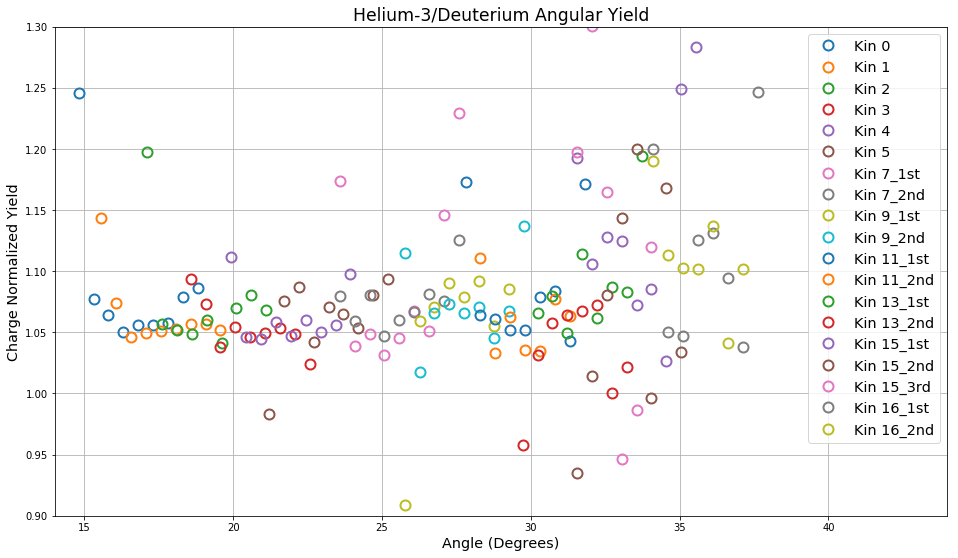

In [9]:
plt.figure(figsize=(16,9))
#,'o',
for i,kin in enumerate(kins):
    plt.plot(pd.Series(He3_th_series[i].index),He3_th_series[i]['Yield']/H2_th_series[i]['Yield'],'o',fillstyle='none',label="Kin " + kin,ms=10,mew=2)

plt.gca().set(xlim=(14,44),ylim=(0.9,1.3))
plt.title('Helium-3/Deuterium Angular Yield',fontsize='xx-large')
plt.xlabel('Angle (Degrees)',fontsize='x-large')
plt.ylabel('Charge Normalized Yield',fontsize='x-large')
#plt.yscale('log')
#plt.xticks(np.arange(0.1,0.901,0.1),fontsize='large')
#plt.yticks(np.arange(0,30.01,5),fontsize='large')
plt.legend(loc=1,fontsize='x-large')
plt.grid()
plt.savefig("th_series/He3_D2_angle.jpg")

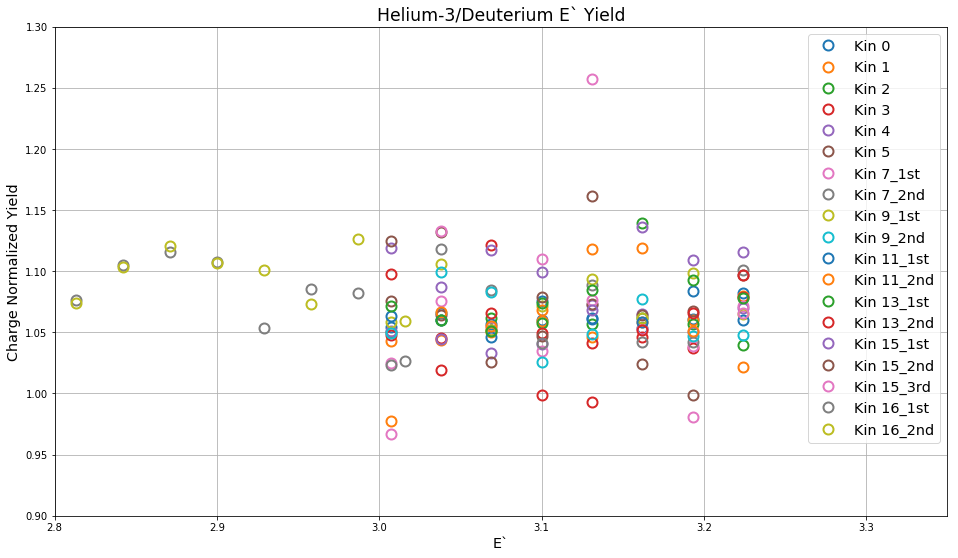

In [10]:
plt.figure(figsize=(16,9))
#,'o',
for i,kin in enumerate(kins):
    plt.plot(pd.Series(He3_dp_series[i].index),He3_dp_series[i]['Yield']/H2_dp_series[i]['Yield'],'o',fillstyle='none',label="Kin " + kin,ms=10,mew=2)

plt.gca().set(xlim=(2.8,3.35),ylim=(0.9,1.3))
plt.title('Helium-3/Deuterium E` Yield',fontsize='xx-large')
plt.xlabel('E`',fontsize='x-large')
plt.ylabel('Charge Normalized Yield',fontsize='x-large')
#plt.yscale('log')
#plt.xticks(np.arange(0.1,0.901,0.1),fontsize='large')
#plt.yticks(np.arange(0,30.01,5),fontsize='large')
plt.legend(loc=1,fontsize='x-large')
plt.grid()
plt.savefig("ep_series/He3_D2_ep.jpg")

In [11]:
for i,kin in enumerate(kins):
    He3_th_series[i].to_csv("th_series/He3/kin" + kin + ".csv")
    He3_dp_series[i].to_csv("ep_series/He3/kin" + kin + ".csv")
    H2_th_series[i].to_csv("th_series/H2/kin" + kin + ".csv")
    H2_dp_series[i].to_csv("ep_series/H2/kin" + kin + ".csv")